In [2]:
import numpy as np
import rasterio
from rasterio.plot import show #limite l'importation de la libairie
from rasterio.plot import show_hist #limite l'importation de la libairie
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy import fft
from scipy import ndimage

import rioxarray as rio
from rasterio.enums import Resampling


In [3]:
filename = '/home/francis/Documents/UQAR/Cours/GEO71021/data_exemple/serpentine_20210308_15min.csv'

bd = pd.read_csv(filename,sep = ',', header = 0)

format = '%Y-%m-%d %H:%M:%S' # spécifie le format dans lequel mon string va être pour créer le datetime

bd['datetime'] = pd.to_datetime(bd['Date'] + ' ' + bd['Time'], format=format) #nouvel colonne datetime
bd = bd.set_index(pd.DatetimeIndex(bd['datetime'])) # je set ma nouvelle datetime comme index
bd

,Date,Time,ValleyRecID,SW-IN,SW-OUT,LW-IN,LW-OUT,PAR-IN,PAR-OUT,AirTemp,...,SnowDepth,PrecipRate,PrecipTotal,BucketWeight,PluvioStatus,WS,WD,WG,BatVolt,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-13 13:00:09,2020-11-13,13:00:09,Valley,76.6,9.7,281.4,328.1,190.9,11.6,2.67,...,-0.2,0.0,483.97,807.0,0,0.6,65.1,2.1,14.29,2020-11-13 13:00:09
2020-11-13 13:15:09,2020-11-13,13:15:09,Valley,104.7,7.3,283.3,326.4,149.9,9.2,2.65,...,-0.2,0.0,483.97,807.0,0,0.1,144.0,1.1,14.30,2020-11-13 13:15:09
2020-11-13 13:30:09,2020-11-13,13:30:09,Valley,53.8,5.7,284.3,325.7,120.6,8.1,2.65,...,0.0,0.0,483.97,807.0,0,0.0,63.9,0.0,14.24,2020-11-13 13:30:09
2020-11-13 13:45:09,2020-11-13,13:45:09,Valley,60.8,5.5,284.1,324.6,117.9,7.2,2.54,...,0.0,0.0,483.97,807.0,0,0.0,270.0,0.0,14.26,2020-11-13 13:45:09
2020-11-13 14:00:09,2020-11-13,14:00:09,Valley,54.1,5.8,281.2,324.2,121.2,7.3,2.38,...,0.1,0.0,483.97,807.0,0,0.8,152.2,2.9,13.68,2020-11-13 14:00:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-08 09:00:09,2021-03-08,09:00:09,Valley,412.6,254.0,236.4,287.5,384.5,592.8,-7.74,...,103.8,0.0,27.45,1387.7,0,3.5,58.5,6.5,14.39,2021-03-08 09:00:09
2021-03-08 09:15:09,2021-03-08,09:15:09,Valley,414.8,355.8,250.0,298.7,718.8,816.7,-7.32,...,103.8,0.0,27.45,1387.7,0,4.3,77.2,7.9,14.28,2021-03-08 09:15:09
2021-03-08 09:30:09,2021-03-08,09:30:09,Valley,522.7,356.0,246.4,301.6,952.3,819.3,-6.74,...,103.8,0.0,27.45,1387.7,0,2.1,344.8,7.2,14.19,2021-03-08 09:30:09


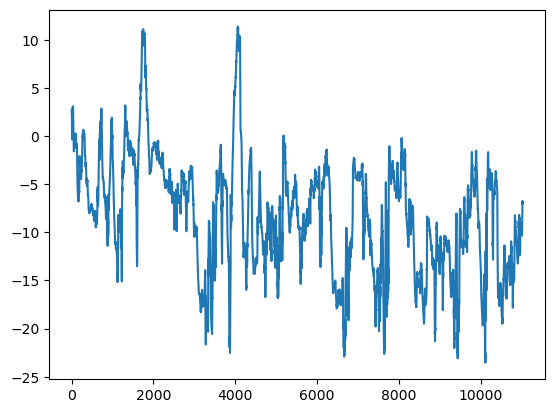

In [4]:
air_temp = np.array(bd['AirTemp'])
plt.plot(air_temp)

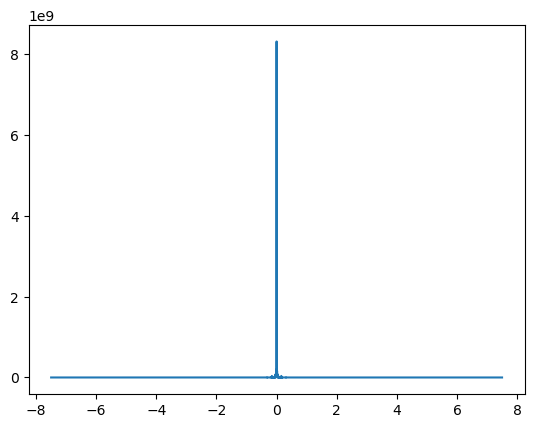

In [5]:
#air_temp = np.array(bd['AirTemp'])

spec_air = np.fft.fft(air_temp)
pspec_air = np.abs(spec_air)**2
N = np.size(air_temp)

time_step = 1/15
freqs = np.fft.fftfreq(pspec_air.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], pspec_air[idx])
#plt.show

/tmp/ipykernel_5997/2086639194.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(f**-1,pxx_den) # rebasculer en minute


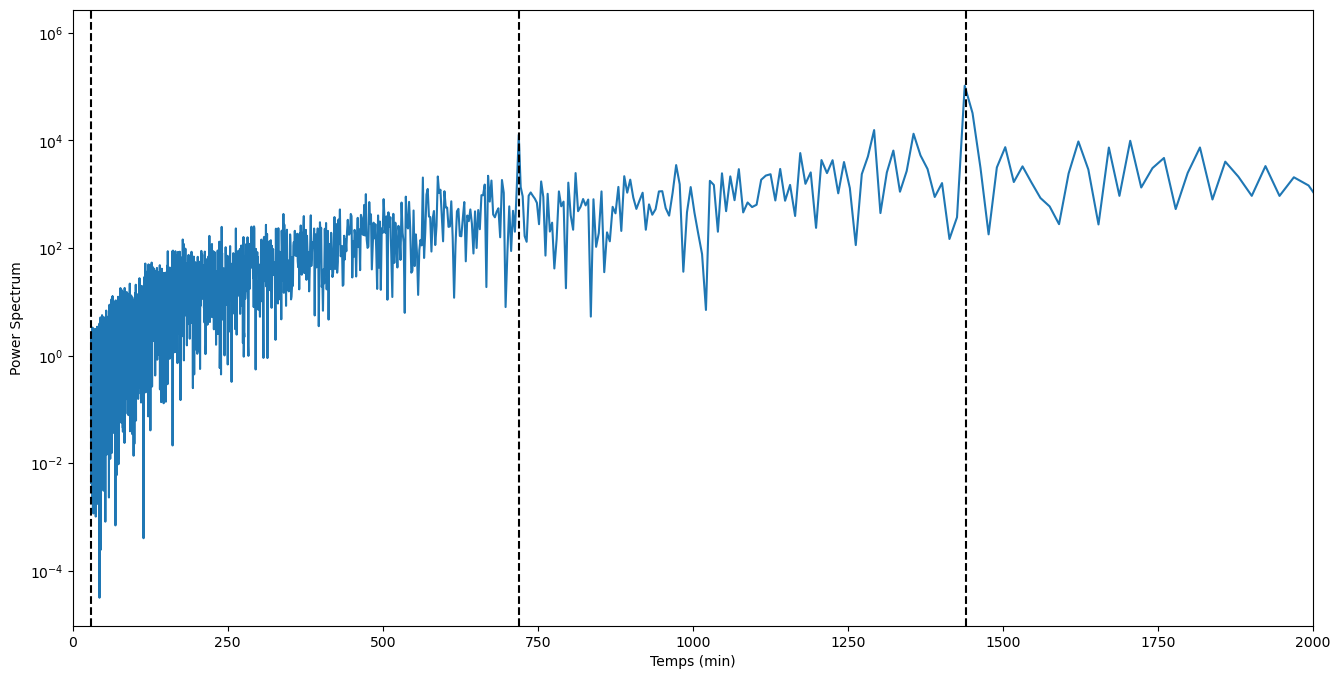

In [6]:
f,pxx_den = signal.periodogram(air_temp,1/15, scaling = 'density')
plt.figure(figsize = (16,8))
plt.semilogy(f**-1,pxx_den) # rebasculer en minute
#plt.ylim([10e2,10e9])
plt.xlim([0,2000])
plt.xlabel('Temps (min)')
plt.ylabel('Power Spectrum')
plt.axvline(x=15*2, color = 'black', linestyle = 'dashed')

plt.axvline(x=1440, color = 'black', linestyle = 'dashed')
plt.axvline(x=720, color = 'black', linestyle = 'dashed')
#plt.axvline(x=480, color = 'black', linestyle = 'dashed')

## Exemple avec un DEM d'hauteur de neige

resolution  0.018056900250032808
upscale_factor 0.036113800500065615
(1, 543, 548)
(0.5007824309649187, -0.5005053550847947)


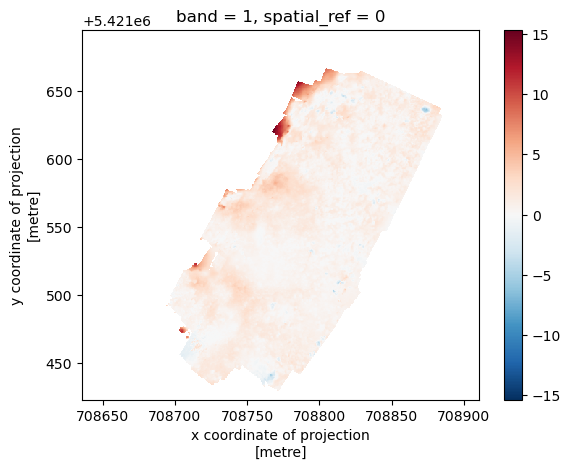

In [7]:
#raster = rasterio.open('/home/francis/Documents/programmation/Qgis/terrain_analysis/DTM_EP.tif',masked=True)
xdr = rio.open_rasterio('/home/francis/Documents/programmation/Qgis/terrain_analysis/snowdepth/epaule_20210317_snowdepth.tif',mask_and_scale = True)
res = xdr.rio.resolution()
# resample data to target shape
print('resolution ',res[0])
upscale_factor = res[0]/0.5 #on s'en va vers une résolution de 0.5m
print('upscale_factor',upscale_factor)
new_width = int(xdr.rio.width * upscale_factor)
new_height = int(xdr.rio.height * upscale_factor)

xdr_resamp = xdr.rio.reproject(xdr.rio.crs, shape = (new_height, new_width), resampling = Resampling.bilinear)
print(xdr_resamp.shape)
print(xdr_resamp.rio.resolution())
xdr_resamp.plot()
res = xdr_resamp.rio.resolution()
x = res[0]
y = res[1]

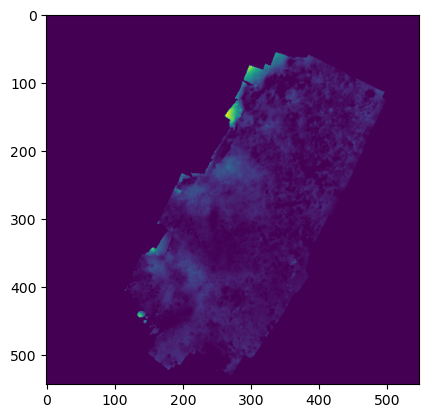

In [9]:
arr = np.array(xdr_resamp[0])
#arr=arr.astype('float')
arr[arr < 0] = 0 # je filtre mes données négative ** ATTENTION que ça fasse du sens avec vos données
arr[np.isnan(arr)] = 0
plt.imshow(arr, cmap= 'viridis')

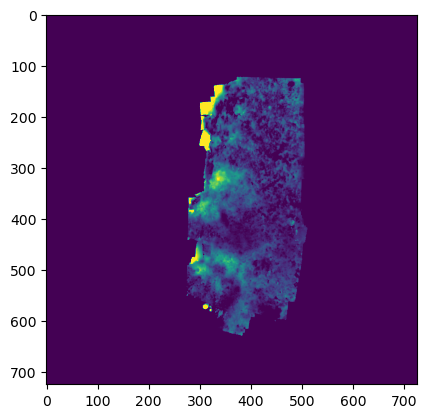

In [12]:
r_arr = ndimage.rotate(arr,25) # je bouge de 25 degré pour mettre droit
plt.imshow(r_arr, cmap= 'viridis',vmin = 0, vmax = 5)

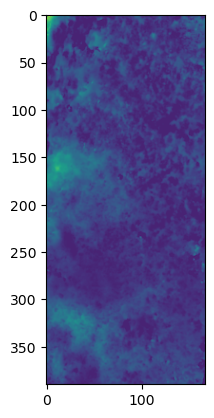

In [16]:
cropped= r_arr[160:550, 325:492] # je sélectionne un beau rectangle pour faire mon analyse
plt.imshow(cropped, cmap= 'viridis')

## Direction en quasi Y (column)

/tmp/ipykernel_5997/1713052369.py:15: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency_snow**-1, ps_snow) # transformation de mes fréquences en distance
/tmp/ipykernel_5997/1713052369.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,200)


Text(0, 0.5, 'Power Spectrum')

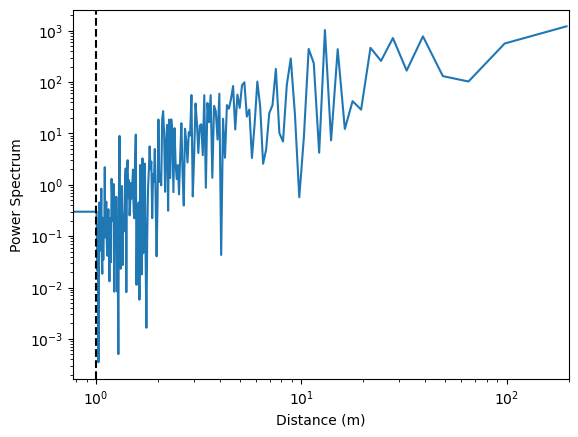

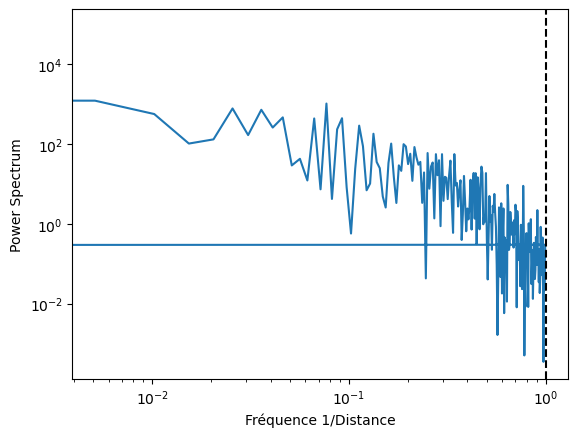

In [25]:
#J'applique mon fft dans l'axe des Y
np.apply_along_axis(np.fft.fft, 0, cropped)
fft = np.apply_along_axis(np.fft.fft, 0, cropped)

#Je fais une moyenne dans l'axe des x 
fft_y = np.median(fft, axis = 1)

#Je calcul mes fréquences
n=fft_y.size
frequency_snow = np.fft.fftfreq(n,x)
ps_snow = np.abs(fft_y)**2

plt.figure(1)
plt.clf()
plt.semilogy(frequency_snow**-1, ps_snow) # transformation de mes fréquences en distance
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlim(0,200)
plt.xlabel('Distance (m)')
plt.ylabel('Power Spectrum')

plt.figure(2)
plt.clf()
plt.semilogy(frequency_snow, ps_snow)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlabel('Fréquence 1/Distance')
plt.ylabel('Power Spectrum')
#plt.xlim(0,200)

(390, 167)
(167,)


/tmp/ipykernel_18671/2738578730.py:11: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_y)
/tmp/ipykernel_18671/2738578730.py:17: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1,ps_y)


(0.0, 50.0)

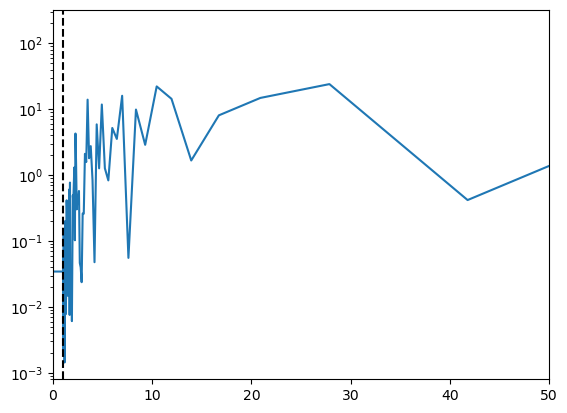

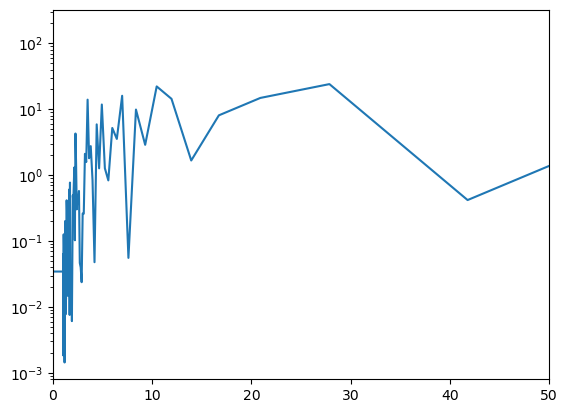

In [36]:

fft = np.apply_along_axis(np.fft.fft, 1, cropped)
print(fft.shape)
fft_y = np.median(fft, axis = 0)
print(fft_y.shape)
n=fft_y.size
frequency = np.fft.fftfreq(n,x)
ps_y = np.abs(fft_y)**2
#frequency = np.linspace(0, x/2, len(ps_y))
plt.figure(1)
plt.clf()
plt.semilogy(frequency**-1, ps_y)
plt.xlim(0,50)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')

plt.figure(2)
plt.clf()
plt.semilogy(frequency**-1,ps_y)
plt.xlim(0,50)

# Comparaison avec le TPI
topographic position index

resolution  0.1
upscale_factor 0.2
(1, 607, 493)
(0.5006085192692596, -0.5006589785826788)


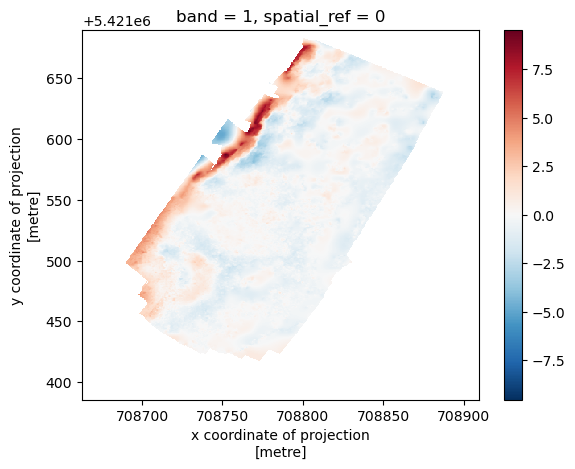

In [26]:
#raster = rasterio.open('/home/francis/Documents/programmation/Qgis/terrain_analysis/DTM_EP.tif',masked=True)
xdr = rio.open_rasterio('/home/francis/Documents/programmation/Qgis/terrain_analysis/TPI/TPI_EP.sdat',masked = True)
res = xdr.rio.resolution()
# resample data to target shape
print('resolution ',res[0])
upscale_factor = res[0]/0.5 #on s'en va vers une résolution de 0.5m
print('upscale_factor',upscale_factor)
new_width = int(xdr.rio.width * upscale_factor)
new_height = int(xdr.rio.height * upscale_factor)

xdr_resamp = xdr.rio.reproject(xdr.rio.crs, shape = (new_height, new_width), resampling = Resampling.bilinear)
print(xdr_resamp.shape)
print(xdr_resamp.rio.resolution())
xdr_resamp.plot()
res = xdr_resamp.rio.resolution()
x = res[0]
y = res[1]

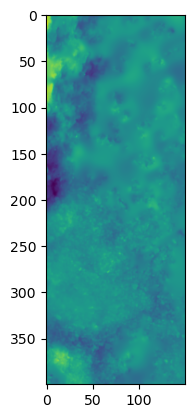

In [27]:
arr = np.array(xdr_resamp[0])
#arr=arr.astype('float')
#arr[arr < 0] = 0
arr[np.isnan(arr)] = 0
r_arr = ndimage.rotate(arr,25)
cropped= r_arr[120:520, 275:425]
plt.imshow(cropped, cmap= 'viridis')

/tmp/ipykernel_5997/162517107.py:15: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_tpi) # transformation de mes fréquences en distance
/tmp/ipykernel_5997/162517107.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,200)


Text(0, 0.5, 'Power Spectrum')

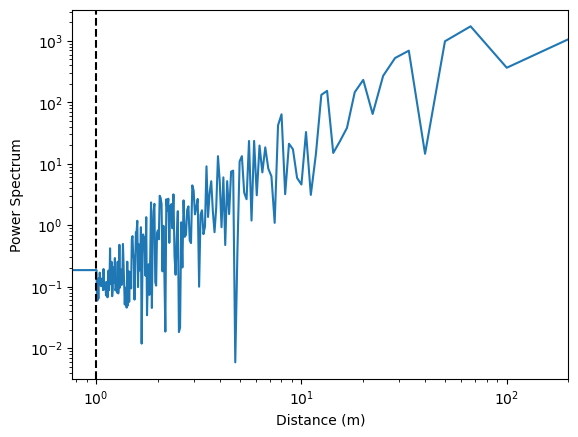

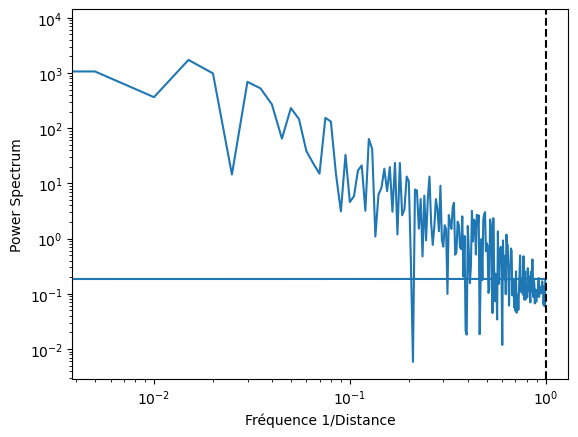

In [29]:
#J'applique mon fft dans l'axe des Y
np.apply_along_axis(np.fft.fft, 0, cropped)
fft = np.apply_along_axis(np.fft.fft, 0, cropped)

#Je fais une moyenne dans l'axe des x 
fft_y = np.median(fft, axis = 1)

#Je calcul mes fréquences
n=fft_y.size
frequency = np.fft.fftfreq(n,x)
ps_tpi = np.abs(fft_y)**2

plt.figure(1)
plt.clf()
plt.semilogy(frequency**-1, ps_tpi) # transformation de mes fréquences en distance
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlim(0,200)
plt.xlabel('Distance (m)')
plt.ylabel('Power Spectrum')

plt.figure(2)
plt.clf()
plt.semilogy(frequency, ps_tpi)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlabel('Fréquence 1/Distance')
plt.ylabel('Power Spectrum')
#plt.xlim(0,200)

resolution  0.023250099886917883
upscale_factor 0.046500199773835765
(1, 607, 493)
(0.5004666578872813, -0.5005091566751173)


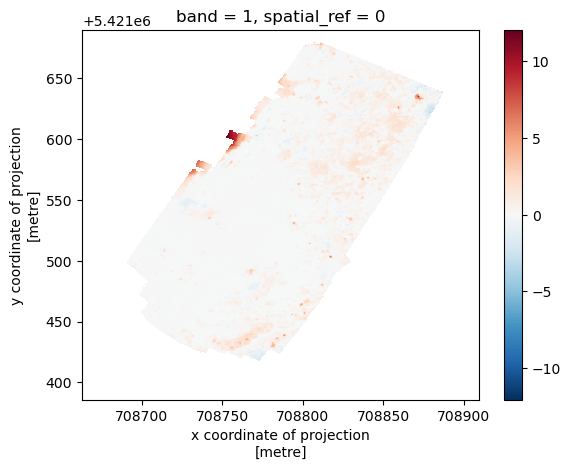

In [30]:
#raster = rasterio.open('/home/francis/Documents/programmation/Qgis/terrain_analysis/DTM_EP.tif',masked=True)
xdr = rio.open_rasterio('/home/francis/Documents/programmation/Qgis/terrain_analysis/canopy/canopy_EP.tif',masked = True)
res = xdr.rio.resolution()
# resample data to target shape
print('resolution ',res[0])
upscale_factor = res[0]/0.5 #on s'en va vers une résolution de 0.5m
print('upscale_factor',upscale_factor)
new_width = int(xdr.rio.width * upscale_factor)
new_height = int(xdr.rio.height * upscale_factor)

xdr_resamp = xdr.rio.reproject(xdr.rio.crs, shape = (new_height, new_width), resampling = Resampling.bilinear)
print(xdr_resamp.shape)
print(xdr_resamp.rio.resolution())
xdr_resamp.plot()
res = xdr_resamp.rio.resolution()
x = res[0]
y = res[1]

[[ 2.21871994e-02  1.52840950e-02 -7.63383647e-03 ... -1.43311862e-02
   4.19595279e-03 -1.89153086e-02]
 [ 2.60634683e-02  8.12166277e-03  1.54449735e-02 ...  1.50207337e-02
   1.08221717e-01  6.92138041e-04]
 [ 1.55049441e-02  7.71061284e-03  9.51373670e-03 ... -1.44645674e-02
   5.97881898e-03  5.41026844e-03]
 ...
 [-3.66345700e-03 -1.02155260e-03 -1.97809626e-04 ...  2.13252963e-03
   2.66545074e-04 -6.56644334e-05]
 [ 2.26452568e-04  7.22624653e-04 -2.10073540e-06 ... -8.38371366e-03
  -4.45423601e-03  4.69437847e-03]
 [ 4.86546378e-05 -2.24254763e-04  9.62397971e-05 ...  7.82723725e-02
   1.20578036e-01  1.81183025e-01]]


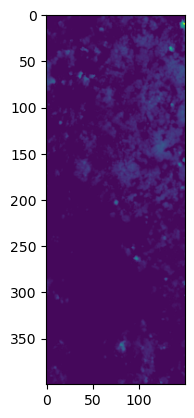

In [31]:
arr = np.array(xdr_resamp[0])
#arr=arr.astype('float')
arr[arr < 0] = 0
arr[np.isnan(arr)] = 0
r_arr = ndimage.rotate(arr,25)
cropped= r_arr[120:520, 275:425]
plt.imshow(cropped, cmap= 'viridis')
print(cropped)

/tmp/ipykernel_5997/1924538918.py:15: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_canopy) # transformation de mes fréquences en distance
/tmp/ipykernel_5997/1924538918.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,200)


Text(0, 0.5, 'Power Spectrum')

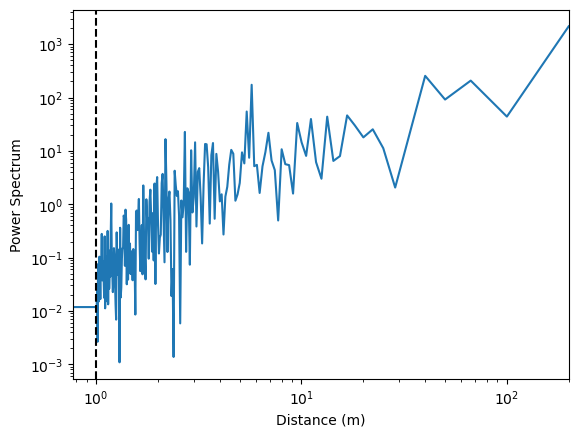

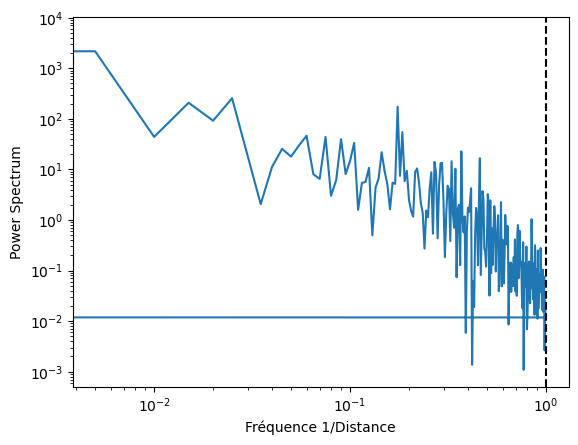

In [32]:
#J'applique mon fft dans l'axe des Y
np.apply_along_axis(np.fft.fft, 0, cropped)
fft = np.apply_along_axis(np.fft.fft, 0, cropped)

#Je fais une moyenne dans l'axe des x 
fft_y = np.median(fft, axis = 1)

#Je calcul mes fréquences
n=fft_y.size
frequency = np.fft.fftfreq(n,x)
ps_canopy = np.abs(fft_y)**2

plt.figure(1)
plt.clf()
plt.semilogy(frequency**-1, ps_canopy) # transformation de mes fréquences en distance
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlim(0,200)
plt.xlabel('Distance (m)')
plt.ylabel('Power Spectrum')

plt.figure(2)
plt.clf()
plt.semilogy(frequency, ps_canopy)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlabel('Fréquence 1/Distance')
plt.ylabel('Power Spectrum')
#plt.xlim(0,200)

## Scaling properties 
L'analyse spectral et le théorême de Parseval nous donne le power spectrum.

Le power spectrum nous dit que l'intégral du signal nous donne la puissance sur signal...

Dans notre cas, on peut voir l'ensemble du signal et l'important de chaque fréquence (échelle) sur la variance totale de notre processus ou variable exploratoire.

Un outil indispensable du géographe!!

On peut également apercevoir une rupture d'échelle autour de 10 m (scale break) entre nos haute et basse fréquence.... ou small-scale et longue-scale.

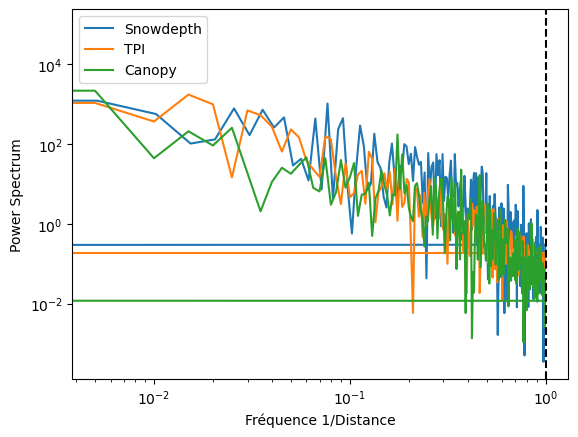

In [36]:
plt.semilogy(frequency_snow, ps_snow, label = 'Snowdepth')
plt.semilogy(frequency, ps_tpi, label = 'TPI')
plt.semilogy(frequency, ps_canopy, label = 'Canopy')

plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlabel('Fréquence 1/Distance')
plt.ylabel('Power Spectrum')
plt.legend()

/tmp/ipykernel_5997/304608409.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency_snow**-1, ps_snow, label = 'Snowdepth')
/tmp/ipykernel_5997/304608409.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_tpi, label = 'TPI')
/tmp/ipykernel_5997/304608409.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_canopy, label = 'Canopy')


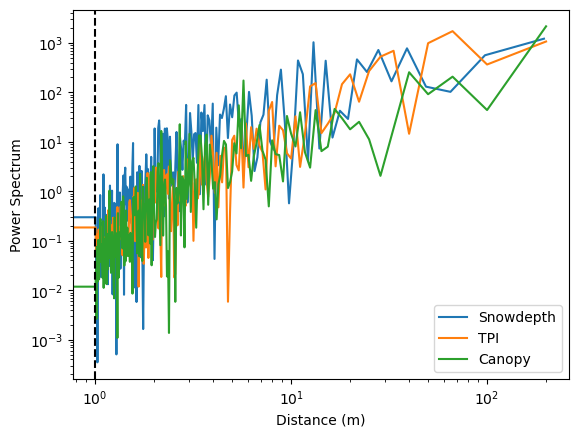

In [35]:
plt.semilogy(frequency_snow**-1, ps_snow, label = 'Snowdepth')
plt.semilogy(frequency**-1, ps_tpi, label = 'TPI')
plt.semilogy(frequency**-1, ps_canopy, label = 'Canopy')

plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlabel('Distance (m)')
plt.ylabel('Power Spectrum')
plt.legend()